In [1]:
#imports
import fitz
from sentence_transformers import SentenceTransformer
from typing import List, Tuple
import pandas as pd
from pacmap import PaCMAP
import numpy as np
import matplotlib.pyplot as plt 
import torch

In [2]:
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

In [3]:

#parameters
data_directory = "Data/"
chunk_size = 750
chunk_overlap = 0


In [4]:
#reading files
def read_txt(file_path): #reading .txt files
    with open(file_path, 'r') as f:
        content = f.read()
        f.close()
    return content


def read_pdf(file_path): #reading .pdf files
    document = fitz.open(file_path)
    text = ""

    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

def read_file(file_path): #one function to read all supported file types
    _, file_extention = os.path.splitext(file_path)

    if file_extention.lower() == '.txt':
        return read_txt(file_path=file_path)
    elif file_extention.lower() == '.pdf':
        return read_pdf(file_path=file_path)
    else:
        return "Unsupported file type"


In [5]:
#storing the data as a corpus
def store_data(data_dir):
    data = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            data.append([file, read_file(os.path.join(root, file))])
    return data


def chunk_data(data, max_chunk_length=500):
    print("Chunking the data...")
    chunks = []
    for file in data:
        content = file[1]
        pdf_length = len(content)
        for i in range(pdf_length//max_chunk_length + 5):
            if content == "":
                break
            contentL = len(content)
            temp_length = min(max_chunk_length, contentL)
            temp_chunk = content[:temp_length]

            dotIndex = temp_chunk.rfind(". ")
            dotIndex2 = temp_chunk.rfind(".\n")
            qIndex = temp_chunk.rfind("? ")
            qIndex2 = temp_chunk.rfind("?\n")
            excIndex = temp_chunk.rfind("! ")
            excIndex2 = temp_chunk.rfind("!\n")
            entIndex = temp_chunk.rfind("\n")

            lastIndex = max(dotIndex, dotIndex2, qIndex, qIndex2, excIndex, excIndex2, entIndex)
            chunk = [file[0], content[:lastIndex]]
            content = content.replace(chunk[1], "", 1)
            chunks.append(chunk)
    return chunks

#embedding the chunks
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(chunks):
    print("Generating embeddings...")
    texts = [chunk[1] for chunk in chunks]
    chunk_embeddings = model.encode(texts)
    return list(zip([chunk[0] for chunk in chunks], chunk_embeddings))
    


In [6]:
#storing the embeddings in a vector DB
class VectorDB:
    def __init__(self):
        self.embeddings = []
        self.metadata = []

    def add_embeddings(self, embeddings: List[Tuple[str, List[float]]]):
        for source, embedding in embeddings:
            self.embeddings.append(embedding)
            self.metadata.append({"source": source})

    #using Euclidian distance for similarity search
    def _euclidean_distance(self, v1, v2):
        score = 0
        for i in range(len(v1)):
            score += (v1[i] - v2[i])**2
        return score * (1 / len(v1))

    def search(self, query_embedding: List[float], top_k: int = 5) -> List[Tuple[float, dict]]:
        if not self.embeddings:
            return []

        distances = [self._euclidean_distance(query_embedding, emb) for emb in self.embeddings]
        
        # Sort distances and get top_k (smallest distances)
        sorted_results = sorted(enumerate(zip(distances, self.metadata)), key=lambda x: x[1][0])

        return [{
            "distance": distance,
            "source": metadata['source'],
            "chunk index": index
        } for index, (distance, metadata) in sorted_results[:top_k]]

    #for seeing how many embeddings are in the vector store
    def __len__(self):
        return len(self.embeddings)
    
    #saving data to a .csv file
    def save(self, filepath: str):
        with open(filepath, 'w') as f:
            for embedding, metadata in zip(self.embeddings, self.metadata):
                embedding_str = ','.join(map(str, embedding))
                f.write(f"{metadata['source']},{embedding_str}\n")

    #loading data from a .csv file
    @classmethod
    def load(cls, filepath: str):
        vector_store = cls()
        with open(filepath, 'r') as f:
            for line in f:
                embedding_str = line.strip().split(',')
                source = embedding_str.pop(0)
                embedding = list(map(float, embedding_str))
                vector_store.embeddings.append(embedding)
                vector_store.metadata.append({"source": source})
        return vector_store


In [7]:
#main body of program
vector_store = VectorDB()
print("Reading Files...")
data = store_data(data_dir=data_directory)
chunked_data = chunk_data(data=data, max_chunk_length=chunk_size)

if not(os.path.exists("vector_store.csv")):    
    embeddings = generate_embeddings(chunked_data)
    vector_store.add_embeddings(embeddings=embeddings)
    print(f"Number of embeddings stored: {len(vector_store)}")
    vector_store.save('vector_store.csv')

else:
    shouldUpdate = input("Do you wish to update the DB? (y/n)")
    if shouldUpdate == 'y':
        embeddings = generate_embeddings(chunked_data)
        vector_store.add_embeddings(embeddings=embeddings)
        print(f"Number of embeddings stored: {len(vector_store)}")
        vector_store.save('vector_store.csv')

    else:
        vector_store = VectorDB.load('vector_store.csv')



Reading Files...
Chunking the data...
Generating embeddings...
Number of embeddings stored: 231


In [8]:
query = input('->')
query_embedding = model.encode([query])[0]

results = vector_store.search(query_embedding, top_k=3)

for result in results:
    print(f"Source: {result['source']}, Distance: {result['distance']:.4f}\n")
    print(result['chunk index'])
    print('\n'.join(chunked_data[result['chunk index']]))
    print()

Source: Alice_in_Wonderland.pdf, Distance: 0.0032

0
Alice_in_Wonderland.pdf
BY LEWIS CARROLL
ILLUSTRATED BY JOHN TENNIEL
NAVIGATE
A L I C E’S
Adventures in W
onderland
CONTROL
CLOSE THE BOOK
TURN THE PAGE
The world’s
most precise
replica
of the world’s 
most famous
children’s book!
In 1998, Peter Zelchenko
began a project for Volume-
One Publishing: to create an
exact digital replica of Lewis
Carroll’s ﬁrst edition of Alice.
Working with the original
1865 edition and numerous
other editions at the Newberry
Library in Chicago, Zelchenko
created a digital masterpiece in
his own right, a testament to
the original work of Lewis
Carroll (aka Prof. Charles
Dodgson) 
who 
personally
directed the typography for the
ﬁrst Alice.
After much analyis, Peter then
painstakingly matched letter to
letter, line to line, of his new

Source: Alice_in_Wonderland.pdf, Distance: 0.0033

1
Alice_in_Wonderland.pdf

digital edition to that of the
original. After weeks of toil he
created an exact replica of the

In [9]:
#my own PaCMAP

# vector_df = pd.read_csv("vector_store.csv", header=None)
# vector_df.columns = ['source'] + list(range(1, vector_df.shape[1]))

# labels = vector_df['source']
# vector_df = vector_df.drop(columns=['source'])

# labels = vector_store.metadata


# u_labels = list(set(labels[i]['source'] for i in range(len(labels))))

# num_labels = []
# for source in labels:
#     num_labels.append(u_labels.index(source['source']))

# pacmap = PaCMAP(n_components=2, n_neighbors=None, MN_ratio=.5, FP_ratio=2.0, random_state=1)

# X_transformed = pacmap.fit_transform(vector_df)

# plt.figure(figsize=(10, 8))
# plt.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap='viridis',s=1 , c=num_labels)

In [10]:
#PaCMAP from hugging face

# vector_df2 = pd.read_csv("vector_store.csv", header=None)
# vector_df2.columns = ['source'] + list(range(1, vector_df2.shape[1]))

# labels = vector_df2['source']
# vector_df2 = vector_df2.drop(columns=['source'])

# documents_projected = pacmap.fit_transform(vector_df2, init="pca")

# labels = vector_store.metadata

# u_labels = list(set(labels[i]['source'] for i in range(len(labels))))

# num_labels = []
# for source in labels:
#     num_labels.append(u_labels.index(source['source']))

# df = pd.DataFrame.from_dict(
#     [
#         {
#             "x": documents_projected[i, 0],
#             "y": documents_projected[i, 1],
#             "source": num_labels[i],
#             "symbol": "circle",
#             "size_col": 4,
#         }
#         for i in range(len(documents_projected))
#     ]
# )

# plt.figure(figsize=(10, 8))
# fig = plt.scatter(
#     df['x'],
#     df['y'],
#     c=df["source"],
#     s=1,
# )

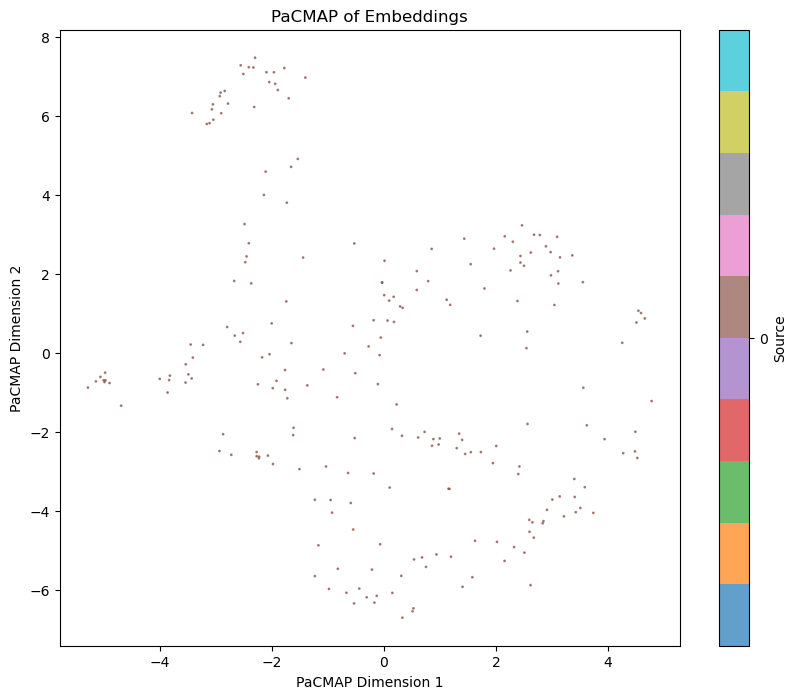

In [11]:
#PaCMAP from GPT4-o

embeddings_data = pd.read_csv('vector_store.csv', header=None)

sources = embeddings_data.iloc[:, 0]
embeddings = embeddings_data.iloc[:, 1:]
pacmap_model = PaCMAP()
embeddings_2d = pacmap_model.fit_transform(embeddings.values)

source_labels, unique_sources = pd.factorize(sources)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=source_labels, cmap='tab10', alpha=0.7, s=1)
plt.colorbar(scatter, ticks=range(len(unique_sources)), label='Source')
plt.clim(-0.5, len(unique_sources) - 0.5)
plt.title('PaCMAP of Embeddings')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.show()

In [12]:
from transformers import BartTokenizer, BartForConditionalGeneration
from llama_index.llms.ollama import Ollama
from llama_index.core import Settings

In [13]:
# tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
# llm_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")

# def generate_responses(query, retrieved_chunks, sources):
#     prompt = f"""
#     You are an LLM specifically designed to answer questions the user asks from provided context or create questions from them.
#     You have to be very precise and tell the use where you got your info from.(this will be provided to you.)
#     The user query is:

#     {query}

#      the context the user is talking about is:

#      """

#     for i in range(len(retrieved_chunks)):
#         prompt += f"""
#         The info is from {sources[i]} and it states: 
        
#         {retrieved_chunks[i]}

#         end of chunk.
#         ---------------------------------------------

#         """

#     prompt += "Now answer the user query. If you can't answer then say you don't know."

#     inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)

#     with torch.no_grad():
#         outputs = llm_model.generate(**inputs, max_new_tokens=200, num_return_sequences=1, temperature=0.2,)

#     response = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     return response

In [16]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Use a model specifically fine-tuned for question answering
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
llm_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

def generate_responses(query, retrieved_chunks, sources):
    context = "\n\n".join([f"From {src}:\n{chunk}" for src, chunk in zip(sources, retrieved_chunks)])
    
    prompt = f"""Answer the following question based on the given context. If the answer is not in the context, say "I don't have enough information to answer this question."

Context:
{context}

Question: {query}

Answer:"""

    inputs = tokenizer(prompt, return_tensors="pt", max_length=4096, truncation=True)

    try:
        with torch.no_grad():
            outputs = llm_model.generate(
                **inputs,
                max_length=4096,
                num_return_sequences=3,
                temperature=0.25,
                top_p=0.95,
                do_sample=True,
                no_repeat_ngram_size=3,
                early_stopping=False
            )
        
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        return response.strip()
    except Exception as e:
        print(f"An error occurred during generation: {e}")
        return "I apologize, but I encountered an error while generating a response."

# In your main loop
while True:
    query = input('->')

    if query.lower() == "quit()":
        break

    query_embedding = model.encode([query])[0]
    results = vector_store.search(query_embedding, top_k=3)

    retrieved_chunks = []
    retrieved_chunks_sources = []

    for result in results:
        retrieved_chunks.append('\n'.join(chunked_data[result['chunk index']]))
        retrieved_chunks_sources.append(result['source'])

    response = generate_responses(query=query, retrieved_chunks=retrieved_chunks, sources=retrieved_chunks_sources)

    print("\nResponse:", response)
    print("\n" + "-"*50 + "\n")


Response: Lewis Carroll

--------------------------------------------------


Response: I don't have enough information to answer this question.

--------------------------------------------------


Response: John Tenniel

--------------------------------------------------


Response: Volume- One Publishing

--------------------------------------------------


Response: I don't have enough information to answer the question.

--------------------------------------------------


Response: Chicago, IL

--------------------------------------------------


Response: 1998

--------------------------------------------------


Response: 1998

--------------------------------------------------


Response: the March Hare

--------------------------------------------------


Response: Dormouse

--------------------------------------------------


Response: I don't have enough information to answer the question.

--------------------------------------------------



In [22]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Use a model specifically fine-tuned for question answering
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
llm_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

def generate_responses(query, retrieved_chunks, sources):
    context = "\n\n".join([f"From {src}:\n{chunk}" for src, chunk in zip(sources, retrieved_chunks)])
    
    prompt = f"""Provide a detailed answer to the following question based on the given context. Use information from the context to support your answer. If the answer is not in the context, explain what information is missing. give as much detail as possible. talk a lot. try to speak like a natural human.

Context:
{context}

Question: {query}

Detailed Answer:"""

    inputs = tokenizer(prompt, return_tensors="pt", max_length=12000, truncation=True)

    try:
        with torch.no_grad():
            outputs = llm_model.generate(
                **inputs,
                min_length=50,  # Encourage longer responses
                max_length=250,  # Allow for even longer responses
                num_return_sequences=1,
                temperature=0.7, 
                top_p=0.95,
                do_sample=True,
                no_repeat_ngram_size=3,
                length_penalty=1.5,  # Encourage longer responses
                early_stopping=True  # Don't stop early to allow for fuller responses
            )
        
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        return response.strip()
    except Exception as e:
        print(f"An error occurred during generation: {e}")
        return "I apologize, but I encountered an error while generating a response."

# In your main loop (keep this part the same)
while True:
    query = input('->')

    if query.lower() == "quit()":
        break

    query_embedding = model.encode([query])[0]
    results = vector_store.search(query_embedding, top_k=3)

    retrieved_chunks = []
    retrieved_chunks_sources = []

    for result in results:
        retrieved_chunks.append('\n'.join(chunked_data[result['chunk index']]))
        retrieved_chunks_sources.append(result['source'])

    response = generate_responses(query=query, retrieved_chunks=retrieved_chunks, sources=retrieved_chunks_sources)

    print("\nResponse:", response)
    print("\n" + "-"*50 + "\n")


Response: a young girl from Wonderland who is trying to learn to draw. She thinks she is a rat. She is the Queen’s sister. She draws drawings. She has a very good memory. She dreams of being in Wonderl land.

--------------------------------------------------


Response: the March Hare. Alice followed the March hare. because she thought the Marchhare would be the most interesting, and thought the Hare would have the most fun. because the Har- es were so interesting. because they were the most entertaining.

--------------------------------------------------


Response: From Alice_in_Wonderland.pdf: Alice_ in_Wontderland.pdf Thus grew the tale of Wonderland: Thus slowly, one by one, Its quaint events were hammered out— And now the tale is done, And home we steer, a merry crew, Beneath the setting sun.

--------------------------------------------------

